# Le Debruiteur
* Jonas Freiburghaus
* Romain Capocasale
* He-Arc, INF3dlm-a
* Image Processing course
* 2019-2020

## Statistics

In [1]:
from debruiteur.generator.datagenerator import DataGenerator
from debruiteur.plots.plots import *
from debruiteur.preprocessing.preprocessor import *
from debruiteur.noise.noise import *
from debruiteur.utils.utils import load_model, split_train_val_df
from debruiteur.noise.filters import *
from debruiteur.statistics.statistics import * 
from debruiteur.metrics.metrics import *

In [2]:
noise_class_list = [
    GaussianNoise(mean=0, std=20),
    PoissonNoise(),
    UniformNoise(amplitude=100),
    SaltPepperNoise(freq=0.3),
    SquareMaskNoise(mask_shape=(10, 10), freq=0.1),
    SpeckleNoise(),
]

### Load data

In [3]:
working_dir = os.path.abspath(os.getcwd())

df_original = make_original_dataframe(os.path.join(working_dir, "images"))
df_resized = make_resized_dataframe(df_original, img_shape=(100, 100), resized_path=os.path.join(working_dir, "resized_images"))
df_noised = make_noised_dataframe(df_resized, noise_class_list, os.path.join(working_dir, "noised_images"))

### Metrics

Mean squared error (MSE) :
$$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

Normalized root mean squared error (NRMSE) :
$$\text{NRMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n}\left(\log{\frac{\hat{y} + 1}{y + 1}}\right)^2}$$

Peak signal to noise ration (PSNR) :
$$\text{PSNR} = 10 \dot \log_{10} \left( \frac{{MAX_{I}^2}}{MSE} \right)$$

Structural similarity (SSIM) :
$$\text{SSIM(x, y)} = \frac{(2\mu_x \mu_y + c_1)(2\sigma_{xy} + c_2)}{(\mu_x^2 + \mu_y^2 + c_1)(\sigma_x^2 + \sigma_y^2 + c_2)}$$

### Show metrics example

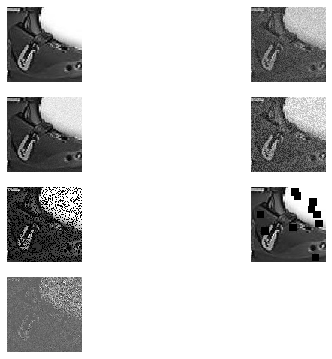

,Noise,MSE,NRMSE,PSNR,SSIM
0,GaussianNoise,2.580302e+07,0.146699,22.144903,0.350864
1,PoissonNoise,1.204587e+09,1.002328,5.453227,0.425459
2,UniformNoise,2.167498e+08,0.425177,12.902020,0.228625
3,SaltPepperNoise,3.534490e+08,0.542943,10.778340,0.239575
4,SquareMaskNoise,2.309548e+08,0.438889,12.626337,0.861240
5,SpeckleNoise,1.202591e+09,1.001497,5.460429,0.105101


In [4]:
metrics_example(df_noised, noise_class_list)

### Create data generator

In [5]:
stats_gen = DataGenerator(df_noised[0:2], batch_size=2)

In [6]:
org = stats_gen[0][1][0].reshape(100,100) 
noised = stats_gen[0][0][0].reshape(100,100)
from skimage import metrics
metrics.normalized_root_mse(org, noised)

0.5799990376406452

### Load models

In [7]:
conv_ae_model = load_model(os.path.join(working_dir, "saved_models"), "conv_autoencoder.h5")
dense_ae_model = load_model(os.path.join(working_dir, "saved_models"), "dense_autoencoder.h5")
gan_model = load_model(os.path.join(working_dir, "saved_models"), "gan_generator.h5")

C:\Users\Romain\AppData\Roaming\Python\Python37\site-packages\tensorflow_core\python\keras\layers\core.py:986: UserWarning: debruiteur.models.gan is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Noise reduction methods

In [8]:
noise_reduction_methods = [('Wiener Filter', lambda img: wiener_filter(img)),
                           ('Laplacian Filter', lambda img: laplacian_filter(img)),
                           ('Gaussian Weighted Filter', lambda img: gaussian_weighted_substract_filter(img)),
                           ('Mean Filter', lambda img: mean_filter(img)),
                           ('Median Filter', lambda img: median_filter(img)),
                           ('Conservative Filter', lambda img: conservative_filter(img)),
                           ('FFT FIlter', lambda img: fft_filter(img)),
                           ('Convolutional Autoencoder', lambda x : conv_ae_model.predict(x.reshape(1, 100, 100, 1)) * 255),
                           ('Dense Autoencoder', lambda x : dense_ae_model.predict(x.reshape(1, 10000)) * 255),
                           ('Generative Adversarial Network', lambda x : gan_model.predict(x.reshape(1, 100, 100, 1)) * 255)]

### Noise reduction methods metrics averaged on all kind of noises

In [9]:
def compute_noise_reduction_method_statistics(dg_images, noise_reduction_methods, img_size=100, verbose=True):
    """Compute the score of each filter for each metrics

    Arguments:
        dg_images {DataGenrator} -- DataGenerator that contain the original images and the noised_image
        noise_reduction_methods {list} -- List of tuple, each tuple contain the name of the noise reduction method and the noise reduction function

    Keyword Arguments:
        img_size {int} -- size of the image, assume the image are square (default: {100})
        verbose {bool} -- display the progression of the statistics (default: {True})

    Returns:
        Dataframe -- Dataframe containing on each column the score with a metric for each noise reduction method
    """
    df_stats = pd.DataFrame(columns=['MSE', 'NRMSE', 'PSNR', 'SSIM'])

    noised_images, original_images = dg_images[0]

    for name, method in noise_reduction_methods:
        mse_values = []
        nrmse_values = []
        psnr_values = []
        ssmi_values = []

        for x, y in zip(noised_images, original_images):
            y_pred = method(x.reshape(img_size, img_size).copy()).reshape(100,100)

            y = y.reshape(100,100)*255
            scores = compare_images(y, y_pred)
            
            mse_values.append(scores['MSE'])
            nrmse_values.append(scores['NRMSE'])
            psnr_values.append(scores['PSNR'])
            ssmi_values.append(scores['SSIM'])
            
            #print(y)
            print(y_pred)
            plt.imshow(y_pred, cmap='gray')
            plt.show()
            break

        df_stats.loc[name] = [statistics.mean(mse_values), statistics.mean(nrmse_values), statistics.mean(psnr_values), statistics.mean(ssmi_values)]

        if verbose:
            print(f"Compute finish for {name}")
    return df_stats

C:\Users\Romain\Desktop\ProjetHeArc\ledebruiteur\debruiteur\metrics\metrics.py:19: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im_true.
  psnr = metrics.peak_signal_noise_ratio(orignal_img / 255, transformed_img / 255)
C:\ProgramData\Anaconda3\lib\site-packages\skimage\metrics\_structural_similarity.py:108: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  im2[..., ch], **args)


[[  5.75129367 -12.00743019  10.37159455 ...  83.84546452  59.40408663
   32.96589937]
 [ -2.89448689   2.65833239  51.69146147 ... 130.65964971  93.41511674
   26.63012837]
 [ 32.08635964  62.30275384 119.64059233 ... 255.         185.83209444
   71.49619779]
 ...
 [ 21.13209633  33.74437543  58.20440444 ...  30.5660497  -12.85000828
    3.74827375]
 [ 11.03731773   5.9091233   25.04203777 ...  75.20013274  39.49892048
   27.66952992]
 [ -3.83120731   2.14382343  27.24167021 ...  53.7609974   33.36497924
   19.39386267]]


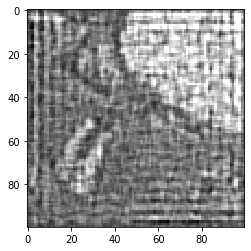

Compute finish for Wiener Filter
[[ 95.40625   97.640625 104.015625 ... 181.36719  171.96875  170.14062 ]
 [116.35156  106.08203   97.265625 ... 178.14453  177.39844  180.10938 ]
 [130.90625  109.19141   94.83203  ... 178.57031  180.4961   183.29688 ]
 ...
 [ 61.914062  61.867188  58.117188 ...  75.04297   76.81641   77.14844 ]
 [ 46.828125  54.382812  59.48828  ...  79.52734   78.10547   76.52344 ]
 [ 35.96875   47.640625  57.015625 ...  83.97656   80.58594   78.4375  ]]


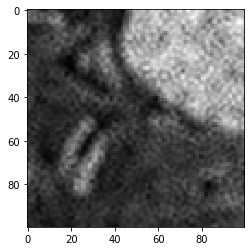

Compute finish for Laplacian Filter
[[136.9996    -14.145458  -47.62257   ... 292.92575   -90.309685
  291.96216  ]
 [  2.0141678  17.353619  171.33212   ... 107.631615   58.876114
  -19.358963 ]
 [-50.170444  131.62614   327.48102   ... 225.46594   253.16522
   93.91457  ]
 ...
 [ 60.59947    18.710892   29.536741  ... 159.00679   -35.0227
  176.29582  ]
 [135.47578   -26.412262   93.91988   ...  70.30957   135.78438
  185.1018   ]
 [210.44078    90.55328   -15.6114025 ...  40.225414   48.702946
   38.020374 ]]


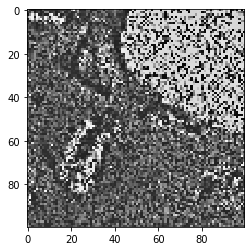

Compute finish for Gaussian Weighted Filter
[[100.04  77.36  86.56 ... 169.44 150.96 152.44]
 [116.88  89.48  93.88 ... 176.72 158.72 162.72]
 [137.28 109.24 115.44 ... 190.08 178.24 176.92]
 ...
 [ 55.68  58.8   60.12 ...  75.52  75.76  77.  ]
 [ 53.16  54.24  58.92 ...  80.84  84.88  86.8 ]
 [ 49.92  47.16  57.72 ...  75.2   81.88  85.56]]


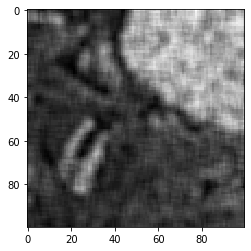

Compute finish for Mean Filter
[[ 45.  35.  24. ... 132. 203. 231.]
 [125.  45.  35. ... 228. 228. 253.]
 [121.  93. 114. ... 244. 231. 253.]
 ...
 [ 67.  66.  58. ...  70.  70.  64.]
 [ 67.  64.  54. ...  63.  64.  64.]
 [ 80.  64.  54. ...  52.  52.  52.]]


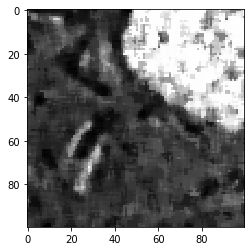

Compute finish for Median Filter
[[125.  24.   1. ... 255.   0. 255.]
 [ 35.  45. 147. ... 132. 100.  48.]
 [  1. 121. 251. ... 212. 231. 125.]
 ...
 [ 58.  30.  37. ... 131.   2. 143.]
 [108.   0.  80. ...  72. 116. 143.]
 [108.  78.   7. ...  52.  58.  51.]]


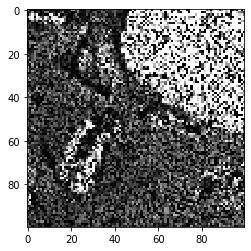

Compute finish for Conservative Filter
[[125.  24.   1. ... 255.   0. 255.]
 [ 35.  45. 147. ... 132. 100.  48.]
 [  0. 121. 251. ... 212. 231. 125.]
 ...
 [ 58.  30.  37. ... 131.   2. 143.]
 [108.   0.  80. ...  72. 116. 149.]
 [158.  78.   7. ...  52.  58.  51.]]
[[277.9484  263.82794 242.90392 ... 271.70956 271.70975 279.2284 ]
 [257.66724 259.90784 272.9994  ... 286.5406  280.87598 272.40356]
 [272.0188  281.99228 287.2858  ... 292.70456 290.55252 280.16226]
 ...
 [257.773   251.91898 267.48282 ... 271.99573 275.3253  272.96112]
 [276.47824 257.1108  251.4311  ... 270.86478 275.38382 280.45667]
 [285.55826 268.78146 198.08737 ... 263.67825 271.71048 284.09723]]


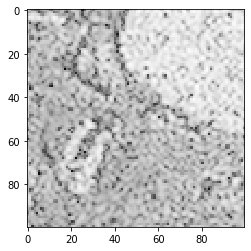

Compute finish for FFT FIlter
[[ 69.467804  51.261723  46.039585 ...  89.17579   92.28457  100.69732 ]
 [ 54.650394  37.495327  32.13571  ...  84.426445  87.43204   97.40527 ]
 [ 50.85074   34.785698  29.60244  ...  95.38188   97.473755 105.28502 ]
 ...
 [ 33.85738   19.249834  17.07568  ...  23.587194  25.57502   41.015274]
 [ 40.55359   24.76515   22.320951 ...  30.661764  32.47732   47.835407]
 [ 54.650265  43.995884  40.886578 ...  46.750572  47.974033  66.73793 ]]


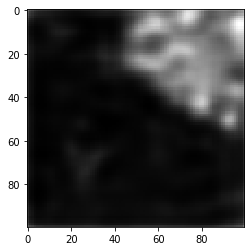

Compute finish for Convolutional Autoencoder
[[166.35944  166.72208  166.25832  ... 157.49799  159.05542  158.85347 ]
 [168.0942   168.67986  168.54393  ... 158.43845  160.08136  158.47684 ]
 [167.18773  167.95784  168.01068  ... 158.01927  159.74161  159.55669 ]
 ...
 [127.550156 125.61717  128.27184  ... 120.54241  123.43979  122.43085 ]
 [127.82214  126.430305 127.53365  ... 123.62716  123.17643  122.981224]
 [131.34941  128.74092  127.19133  ... 124.253876 125.4359   123.6641  ]]


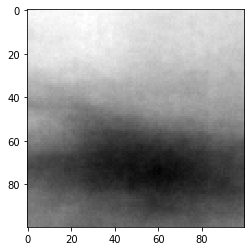

Compute finish for Dense Autoencoder
[[ 67.84493    20.476364    6.827284  ... 129.88411    22.705833
  139.53221  ]
 [ 22.096539   25.096333   73.76723   ... 110.82233    82.556404
   50.709816 ]
 [  9.535816   64.579796  125.91734   ... 168.72107   137.85892
   97.39145  ]
 ...
 [ 31.891005   16.349754   19.590664  ...  66.23067     4.787652
   72.637535 ]
 [ 56.507668    2.1305077  40.422462  ...  38.302586   58.60077
   75.94913  ]
 [ 85.745605   40.51957     5.6342998 ...  27.77433    30.849863
   32.276123 ]]


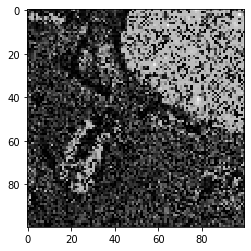

Compute finish for Generative Adversarial Network


,MSE,NRMSE,PSNR,SSIM
Wiener Filter,2.466317e+08,0.453540,12.341118,0.169100
Laplacian Filter,1.359825e+08,0.336769,14.926778,0.109016
Gaussian Weighted Filter,7.915402e+08,0.812507,7.276878,0.080812
Mean Filter,1.253339e+08,0.323314,15.280921,0.212920
Median Filter,7.838268e+07,0.255682,17.319406,0.176935
Conservative Filter,3.934158e+08,0.572818,10.313089,0.127068
FFT FIlter,2.055308e+09,1.309270,3.132837,0.077378
Convolutional Autoencoder,6.474992e+08,0.734870,8.149215,0.023091
Dense Autoencoder,4.119133e+08,0.586130,10.113549,0.066005
Generative Adversarial Network,4.928344e+08,0.641123,9.334597,0.142878


In [10]:
compute_noise_reduction_method_statistics(stats_gen, noise_reduction_methods)

In [11]:
org = stats_gen[0][1][11]
noised = stats_gen[0][0][11]
plt.imshow(org.reshape(100,100), cmap='gray')
plt.show()

plt.imshow(noised.reshape(100,100), cmap='gray')
plt.show()

y_pred = wiener_filter(noised.reshape(100,100))
plt.imshow(y_pred.reshape(100,100), cmap='gray')
plt.show()

print(metrics.structural_similarity(org.reshape(100,100), y_pred.reshape(100,100)))
print(org)
print(y_pred)

IndexError: index 11 is out of bounds for axis 0 with size 2

### Noise reductions methods for each noise type

In [ ]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "SSIM")

In [ ]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "PSNR")

In [ ]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "MSE")

In [ ]:
compute_noise_type_statistics(stats_gen, noise_reduction_methods, noise_class_list, "NRMSE")